classification_age_fractal applies multiple classifications methods over Katz fractal dimensions values obtains using ECG ROI's. The ROI's are defined using ECG_R_Peaks fiducial point as center reference of a window of size 300 samples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import neurokit2 as nk

In [2]:
normal_ecg_age = pd.read_pickle('normal_ecg_age.pickle')
normal_ecg_age.head()

ECG_ID  Age  Age_class_0  Age_class_1  Age_class_2  Age_class_3
0  A00002   32            2            1            0            0
1  A00003   63            5            2            1            1
2  A00006   46            3            1            1            0
3  A00008   32            2            1            0            0
4  A00009   48            3            1            1            0

Code used to clear previously created ECG_R_Peaks dataframe. Now will be considered signal read error to depurate normal_ecg_age dataset of normal ECG signals and corresponding ages.

In [7]:
for id in normal_ecg_age['ECG_ID']:
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/{id}.h5', 'r+') as f:
        del f['ECG_R_Peaks']

Create h5py dataframe of R peaks: ['ECG_R_Peaks'][...]. Procedure also creates pickles files containing:
 - ecg_signal_read_error: pickle file containing ['ECG_ID', 'Derivation'] of signal read error OSError.
 - ecg_multiple_r_peaks_detection: pickle file containing ['ECG_ID', 'Derivation'] of signal with multiple R Peaks detection.
 - ecg_r_peaks_missing: pickle file containing ['ECG_ID', 'Derivation'] of signal with miss detection and -1 included because NaN is of type float.

Dataframe in the form rows: derivations, columns: ECG_R_Peaks fiducial points.

In [34]:
ecg_signal_read_error = pd.DataFrame(columns=['ECG_ID', 'Derivation'])
ecg_multiple_r_peaks_detection = pd.DataFrame(columns=['ECG_ID', 'Derivation'])
ecg_r_peaks_missing = pd.DataFrame(columns=['ECG_ID', 'Derivation'])
for id in normal_ecg_age['ECG_ID']:
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/{id}.h5', 'r+') as f:
        for der in range (12):
            try:
                ecg_sig = f['ecg'][der]
            except OSError:
                print(f'ECG signal: {id}, derivation: {der}. Couldnot be read')
                ecg_signal_read_error.loc[len(ecg_signal_read_error)] = [id, der]
                continue
            ecg_fixed, is_inverted = nk.ecg_invert(ecg_sig, sampling_rate=500)
            if is_inverted:
                ecg_sig = ecg_fixed    
            signals, _ = nk.ecg_process(ecg_sig, sampling_rate=500)
            roi_ref = list(signals[signals['ECG_R_Peaks'] == 1].index)
            if der == 0:
                ECG_R_Peaks_dataframe = pd.DataFrame(columns=[c for c in range(len(roi_ref))])            
            else:
                while len(roi_ref) > len(ECG_R_Peaks_dataframe.columns):
                    interval_difference = [0] * (len(roi_ref) - 1)
                    for i in range(len(roi_ref) - 1):
                        interval_difference[i] = roi_ref[i + 1] - roi_ref[i]
                    index_min_interval = interval_difference.index(min(interval_difference)) + 1
                    ecg_multiple_r_peaks_detection.loc[len(ecg_multiple_r_peaks_detection)] = [id, der]
                    roi_ref.pop(index_min_interval)
                while len(roi_ref) < len(ECG_R_Peaks_dataframe.columns):
                    roi_ref.append(-1)
                    ecg_r_peaks_missing.loc[len(ecg_r_peaks_missing)] = [id, der]
            ECG_R_Peaks_dataframe.loc[len(ECG_R_Peaks_dataframe)] = roi_ref
        #ECG_R_Peaks_dataframe.index = [['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']]
        f['ECG_R_Peaks'] = ECG_R_Peaks_dataframe
        del ECG_R_Peaks_dataframe
        f.close()
ecg_signal_read_error.to_pickle('ecg_signal_read_error.pickle')
ecg_multiple_r_peaks_detection.to_pickle('ecg_multiple_r_peaks_detection.pickle')
ecg_r_peaks_missing.to_pickle('ecg_r_peaks_missing.pickle')

c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A00537, derivation: 9. Couldnot be read
ECG signal: A00537, derivation: 10. Couldnot be read
ECG signal: A00537, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A01188, derivation: 9. Couldnot be read
ECG signal: A01188, derivation: 10. Couldnot be read
ECG signal: A01188, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A01206, derivation: 9. Couldnot be read
ECG signal: A01206, derivation: 10. Couldnot be read
ECG signal: A01206, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A01736, derivation: 9. Couldnot be read
ECG signal: A01736, derivation: 10. Couldnot be read
ECG signal: A01736, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A02568, derivation: 9. Couldnot be read
ECG signal: A02568, derivation: 10. Couldnot be read
ECG signal: A02568, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A03360, derivation: 9. Couldnot be read
ECG signal: A03360, derivation: 10. Couldnot be read
ECG signal: A03360, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A03608, derivation: 9. Couldnot be read
ECG signal: A03608, derivation: 10. Couldnot be read
ECG signal: A03608, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A03898, derivation: 9. Couldnot be read
ECG signal: A03898, derivation: 10. Couldnot be read
ECG signal: A03898, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A05931, derivation: 9. Couldnot be read
ECG signal: A05931, derivation: 10. Couldnot be read
ECG signal: A05931, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A06236, derivation: 9. Couldnot be read
ECG signal: A06236, derivation: 10. Couldnot be read
ECG signal: A06236, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A06955, derivation: 9. Couldnot be read
ECG signal: A06955, derivation: 10. Couldnot be read
ECG signal: A06955, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A08363, derivation: 9. Couldnot be read
ECG signal: A08363, derivation: 10. Couldnot be read
ECG signal: A08363, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A08544, derivation: 9. Couldnot be read
ECG signal: A08544, derivation: 10. Couldnot be read
ECG signal: A08544, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A09809, derivation: 9. Couldnot be read
ECG signal: A09809, derivation: 10. Couldnot be read
ECG signal: A09809, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A11201, derivation: 9. Couldnot be read
ECG signal: A11201, derivation: 10. Couldnot be read
ECG signal: A11201, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A11483, derivation: 9. Couldnot be read
ECG signal: A11483, derivation: 10. Couldnot be read
ECG signal: A11483, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A11967, derivation: 9. Couldnot be read
ECG signal: A11967, derivation: 10. Couldnot be read
ECG signal: A11967, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A12062, derivation: 9. Couldnot be read
ECG signal: A12062, derivation: 10. Couldnot be read
ECG signal: A12062, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A13820, derivation: 9. Couldnot be read
ECG signal: A13820, derivation: 10. Couldnot be read
ECG signal: A13820, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A14998, derivation: 9. Couldnot be read
ECG signal: A14998, derivation: 10. Couldnot be read
ECG signal: A14998, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A15500, derivation: 9. Couldnot be read
ECG signal: A15500, derivation: 10. Couldnot be read
ECG signal: A15500, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A15701, derivation: 9. Couldnot be read
ECG signal: A15701, derivation: 10. Couldnot be read
ECG signal: A15701, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A16655, derivation: 9. Couldnot be read
ECG signal: A16655, derivation: 10. Couldnot be read
ECG signal: A16655, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A16790, derivation: 9. Couldnot be read
ECG signal: A16790, derivation: 10. Couldnot be read
ECG signal: A16790, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A17190, derivation: 9. Couldnot be read
ECG signal: A17190, derivation: 10. Couldnot be read
ECG signal: A17190, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A17650, derivation: 9. Couldnot be read
ECG signal: A17650, derivation: 10. Couldnot be read
ECG signal: A17650, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A17864, derivation: 9. Couldnot be read
ECG signal: A17864, derivation: 10. Couldnot be read
ECG signal: A17864, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A18231, derivation: 9. Couldnot be read
ECG signal: A18231, derivation: 10. Couldnot be read
ECG signal: A18231, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A19345, derivation: 9. Couldnot be read
ECG signal: A19345, derivation: 10. Couldnot be read
ECG signal: A19345, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A19367, derivation: 9. Couldnot be read
ECG signal: A19367, derivation: 10. Couldnot be read
ECG signal: A19367, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A19405, derivation: 9. Couldnot be read
ECG signal: A19405, derivation: 10. Couldnot be read
ECG signal: A19405, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A19501, derivation: 9. Couldnot be read
ECG signal: A19501, derivation: 10. Couldnot be read
ECG signal: A19501, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A21253, derivation: 9. Couldnot be read
ECG signal: A21253, derivation: 10. Couldnot be read
ECG signal: A21253, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A22207, derivation: 9. Couldnot be read
ECG signal: A22207, derivation: 10. Couldnot be read
ECG signal: A22207, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

ECG signal: A22501, derivation: 9. Couldnot be read
ECG signal: A22501, derivation: 10. Couldnot be read
ECG signal: A22501, derivation: 11. Couldnot be read


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

Following procedure creates h5py dataframe of Katz fractal dimension values obtained around detected ECG R Peaks (ROI = [-150 + ECG_R_Peaks: 150 + ECG_R_Peaks]). 

Dataframe in the form rows: derivations, columns: Katz fractal dimension values

In [ ]:
for id in normal_ecg_age['ECG_ID'][:100]:
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/{id}.h5', 'r+') as f:
        signal = f['ecg'][...]
        r_peaks = f['ECG_R_Peaks'][...]
        row,col = r_peaks.shape
        Katz_DataFrame = pd.DataFrame(columns=[c for c in range(col)])
        Katz_list = [np.NaN]*col
        index = range(12)
        for index, r in zip(index, r_peaks):
            for c in range(col):
                if r[c] != -1:
                    Katz_list[c],_ = nk.fractal_katz(signal[index][r[c] - 150:r[c] + 150])
                else:
                    Katz_list[c] = Katz_list[c - 1]
            Katz_DataFrame.loc[len(Katz_DataFrame)] = Katz_list
            Katz_list = [np.NaN]*col
        mn = pd.Series(np.mean(Katz_DataFrame, axis=1))
        mn.name = col
        std = pd.Series(np.std(Katz_DataFrame, axis=1))
        std.name = col + 1
        Katz_DataFrame = pd.concat([Katz_DataFrame, mn, std], axis=1)
        f['Katz_fractal'] = Katz_DataFrame
        del Katz_DataFrame, r_peaks, mn, std
        f.close()

In [29]:
with h5py.File('E:/1-DENIS/Biomarkers/SPH dataset/records/A00038.h5', 'r+') as f:
    peaks = f['ECG_R_Peaks'][...]

In [4]:
Katz_DataFrame

0         1         2         3         4         5         6   \
0   1.245117  1.245117  1.250977  1.249023  1.264648  1.244141  1.237305   
1   1.205078  1.190430  1.195312  1.201172  1.196289  1.194336  1.190430   
2   1.280273  1.227539  1.244141  1.263672  1.232422  1.253906  1.251953   
3   1.217773  1.206055  1.214844  1.213867  1.215820  1.210938  1.206055   
4   1.356445  1.359375  1.365234  1.353516  1.446289  1.353516  1.333008   
5   1.209961  1.183594  1.189453  1.201172  1.187500  1.190430  1.191406   
6   1.209961  1.189453  1.190430  1.189453  1.189453  1.196289  1.190430   
7   1.250977  1.249023  1.245117  1.245117  1.253906  1.242188  1.243164   
8   1.357422  1.365234  1.375977  1.394531  1.354492  1.346680  1.387695   
9   1.251953  1.244141  1.267578  1.267578  1.264648  1.252930  1.255859   
10  1.214844  1.196289  1.190430  1.204102  1.216797  1.201172  1.209961   
11  1.163086  1.162109  1.173828  1.184570  1.172852  1.175781  1.184570   

          7         8         9         10        11        12        13  \
0   1.245117  1.256836  1.241211  1.241211  1.249023  1.245117  1.242188   
1   1.194336  1.192383  1.191406  1.196289  1.190430  1.194336  1.191406   
2   1.254883  1.239258  1.246094  1.250977  1.238281  1.238281  1.257812   
3   1.210938  1.210938  1.205078  1.209961  1.209961  1.208984  1.210938   
4   1.344727  1.414062  1.377930  1.337891  1.369141  1.387695  1.338867   
5   1.192383  1.190430  1.188477  1.198242  1.190430  1.190430  1.190430   
6   1.194336  1.197266  1.192383  1.198242  1.194336  1.194336  1.195312   
7   1.241211  1.245117  1.244141  1.244141  1.244141  1.249023  1.247070   
8   1.351562  1.348633  1.375977  1.411133  1.389648  1.416992  1.404297   
9   1.256836  1.253906  1.257812  1.250000  1.257812  1.256836  1.267578   
10  1.225586  1.213867  1.198242  1.204102  1.202148  1.203125  1.199219   
11  1.178711  1.159180  1.186523  1.195312  1.191406  1.170898  1.173828   

          14        15  
0   1.248047  0.006752  
1   1.194336  0.004116  
2   1.248047  0.013176  
3   1.210938  0.003605  
4   1.367188  0.030334  
5   1.192383  0.006355  
6   1.194336  0.005203  
7   1.245117  0.003435  
8   1.377930  0.023132  
9   1.256836  0.006863  
10  1.205078  0.009071  
11  1.176758  0.010551

In [20]:
for id in normal_ecg_age['ECG_ID'][:100]:
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/{id}.h5', 'r+') as f:
        del f['Katz_fractal']

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [11]:
np.std(k, axis=1)

array([0.006756, 0.00412 , 0.01318 , 0.003605, 0.03033 , 0.006355,
       0.005203, 0.003546, 0.02313 , 0.006866, 0.00909 , 0.01055 ],
      dtype=float16)

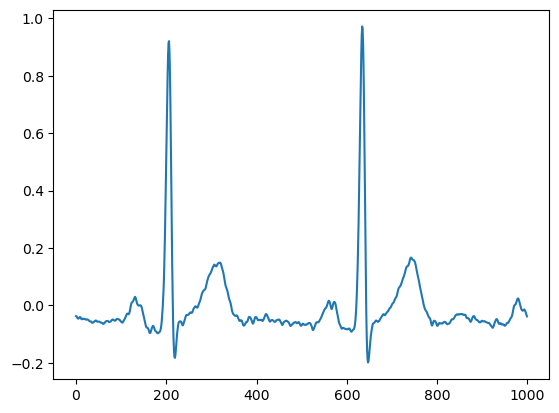

In [33]:
plt.plot(sig[0][:1000])

In [27]:
with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/A00535.h5', 'r+') as f:
    try:
        del f['ECG_R_Peaks']
    except KeyError:
        continue

SyntaxError: 'continue' not properly in loop (3671139208.py, line 5)

In [25]:
for id in normal_ecg_age['ECG_ID']:
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/A00535.h5', 'r+') as f:
        try:
            del f['ECG_R_Peaks']
        except KeyError:
            continue

KeyboardInterrupt: 

In [ ]:
kdf = []
w = 0
overlap = 500
for i in range(int(len(ecg_sig)/(1000 - overlap)) - 1):
    segment = ecg_sig[w: min(w + 1000, len(ecg_sig))]
    fig = plt.figure()
    plt.plot(segment)
    w = w + overlap
    kfd_temp, _ = nk.fractal_katz(segment)
    print(kfd_temp)
    kdf.append(kfd_temp)

In [ ]:
kdf

Load Kats fractal dimension

In [ ]:
normal_ecg_katz = pd.read_pickle('normal_ecg_katz.pickle')
normal_ecg_katz.head(1)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
normal_ecg_katz.iloc[:,1:13]

In [ ]:
pca = PCA(n_components=4).fit(normal_ecg_katz.iloc[:,1:13])

In [ ]:
new_pca = pca.transform(normal_ecg_katz.iloc[:,1:13])

In [ ]:
new_pca.shape

In [ ]:
normal_ecg_age = pd.read_pickle('normal_ecg_age.pickle')
normal_ecg_age = normal_ecg_age.drop(['Age'], axis=1)
normal_ecg_age.head(1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_pca, normal_ecg_age['Age_class_3'], random_state=0)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
Katz_age = normal_ecg_katz.join(normal_ecg_age, on=None, how='left', lsuffix='ID', rsuffix='ECG_ID', sort=False, validate=None)

In [ ]:
Katz_age.drop(['ID', 'ECG_ID'], axis=1, inplace=True)

In [ ]:
Katz_age

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Katz_age.iloc[:,0:12], Katz_age['Age_class_0'], random_state=0)

In [ ]:
pd.concat([X_train, y_train], axis=1)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree.score(X_test, y_test)))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Katz_age.iloc[:,0:12], Katz_age['Age_class_1'], random_state=0)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree.score(X_test, y_test)))

In [ ]:
def plot_feature_importances_Katz_tree(model):
    n_features = Katz_age.shape[1] - 4
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Katz_age.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_Katz_tree(tree)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Katz_age.iloc[:,0:12], Katz_age['Age_class_2'], random_state=0)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree.score(X_test, y_test)))

In [ ]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Katz_age.iloc[:,0:12], Katz_age['Age_class_3'], random_state=0)
#from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
#from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(tree.score(X_test, y_test)))

In [ ]:
Katz_age.columns

In [ ]:
def plot_feature_importances_Katz_tree(model):
    n_features = Katz_age.shape[1] - 4
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), Katz_age.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances_Katz_tree(tree)

In [ ]:
import graphviz

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
feature_names=cancer.feature_names, impurity=False, filled=True)

Dimensionality reduction

In [ ]:
test = pd.DataFrame(index=[['a', 'b', 'c', 'd']], columns=[[1, 2, 3, 4]])

In [ ]:
test

In [ ]:
del test